# Analyse du marché de l’emploi dans la Data

Ce projet vise à analyser le marché de l’emploi dans le domaine de la Data
(Data Science, Data Analysis, Intelligence Artificielle) à partir d’offres
d’emploi réelles.

L’analyse repose sur trois datasets :
- job_postings.csv : informations générales sur les offres d’emploi
- job_skills.csv : compétences associées à chaque offre
- job_summary.csv : informations et indicateurs synthétiques

L’objectif est d’identifier les métiers les plus demandés, les compétences clés
et de comprendre les tendances générales du marché.

Ce notebook correspond à la phase d’exploration des données.


In [27]:

data_dir <- if (dir.exists('../data/raw')) '../data/raw' else 'data/raw'
if (!dir.exists(data_dir)) stop('data/raw folder not found')

files <- c(
  job_postings = 'job_postings.csv',
  job_skills   = 'job_skills.csv',
  job_summary  = 'job_summary.csv'
)

read_safe <- function(fname) {
  path <- file.path(data_dir, fname)
  if (!file.exists(path)) stop(paste('Missing file:', path))
  read.csv(path, stringsAsFactors = FALSE)
}

list2env(lapply(files, read_safe), envir = .GlobalEnv)


<environment: R_GlobalEnv>

## Aperçu général des datasets

Cette étape permet d’avoir une première vue d’ensemble sur les données :
- Nombre de lignes et de colonnes
- Noms des variables
- Structure générale des datasets

Cela aide à comprendre le contenu des fichiers avant d’aller plus loin
dans l’analyse.


In [28]:
# Dimensions des datasets
dim(job_postings)
dim(job_skills)
dim(job_summary)

# Noms des colonnes
names(job_postings)
names(job_skills)
names(job_summary)

# Structure des données
str(job_postings)
str(job_skills)
str(job_summary)


[1] 12217    15

[1] 12217     2

[1] 12217     2

[1] "job_link"            "last_processed_time" "last_status"        
 [4] "got_summary"         "got_ner"             "is_being_worked"    
 [7] "job_title"           "company"             "job_location"       
[10] "first_seen"          "search_city"         "search_country"     
[13] "search_position"     "job_level"           "job_type"

[1] "job_link"   "job_skills"

[1] "job_link"    "job_summary"

'data.frame':	12217 obs. of  15 variables:
 $ job_link           : chr  "https://www.linkedin.com/jobs/view/senior-machine-learning-engineer-at-jobs-for-humanity-3804053819" "https://www.linkedin.com/jobs/view/principal-software-engineer-ml-accelerators-at-aurora-3703455068" "https://www.linkedin.com/jobs/view/senior-etl-data-warehouse-specialist-at-adame-services-llc-3765023888" "https://www.linkedin.com/jobs/view/senior-data-warehouse-developer-architect-at-morph-enterprise-3794602483" ...
 $ last_processed_time: chr  "2024-01-21 08:08:48.031964+00" "2024-01-20 04:02:12.331406+00" "2024-01-21 08:08:31.941595+00" "2024-01-20 15:30:55.796572+00" ...
 $ last_status        : chr  "Finished NER" "Finished NER" "Finished NER" "Finished NER" ...
 $ got_summary        : chr  "t" "t" "t" "t" ...
 $ got_ner            : chr  "t" "t" "t" "t" ...
 $ is_being_worked    : chr  "f" "f" "f" "f" ...
 $ job_title          : chr  "Senior Machine Learning Engineer" "Principal Software Engineer, ML Accel

## Interprétation de la structure des données

Les trois datasets contiennent le même nombre d’observations (12 217 lignes),
ce qui indique qu’ils décrivent les mêmes offres d’emploi.

- Le dataset **job_postings** contient les informations principales sur les
  offres (poste, entreprise, localisation, type de poste, niveau, etc.).
- Le dataset **job_skills** associe à chaque offre une liste de compétences
  techniques sous forme de texte.
- Le dataset **job_summary** contient une description textuelle détaillée
  des offres d’emploi.

Les datasets sont reliés entre eux par la variable commune **job_link**,
qui servira de clé pour les jointures dans les étapes suivantes.


In [29]:
# Aperçu des premières lignes
head(job_postings, 2)
head(job_skills, 2)
head(job_summary, 1)

# Vérification des valeurs manquantes (NA)
colSums(is.na(job_postings))
colSums(is.na(job_skills))
colSums(is.na(job_summary))


job_link,last_processed_time,last_status,got_summary,got_ner,is_being_worked,job_title,company,job_location,first_seen,search_city,search_country,search_position,job_level,job_type
https://www.linkedin.com/jobs/view/senior-machine-learning-engineer-at-jobs-for-humanity-3804053819,2024-01-21 08:08:48.031964+00,Finished NER,t,t,f,Senior Machine Learning Engineer,Jobs for Humanity,"New Haven, CT",2024-01-14,East Haven,United States,Agricultural-Research Engineer,Mid senior,Onsite
https://www.linkedin.com/jobs/view/principal-software-engineer-ml-accelerators-at-aurora-3703455068,2024-01-20 04:02:12.331406+00,Finished NER,t,t,f,"Principal Software Engineer, ML Accelerators",Aurora,"San Francisco, CA",2024-01-14,El Cerrito,United States,Set-Key Driver,Mid senior,Onsite


job_link,job_skills
https://www.linkedin.com/jobs/view/senior-machine-learning-engineer-at-jobs-for-humanity-3804053819,"Machine Learning, Programming, Python, Scala, Java, Data Engineering, Distributed Computing, Statistical Modeling, Optimization, Data Pipelines, Cloud Computing, DevOps, Software Development, Data Gathering, Data Preparation, Data Visualization, Machine Learning Frameworks, scikitlearn, PyTorch, Dask, Spark, TensorFlow, Distributed File Systems, Multi node Database Paradigms, Open Source ML Software, Responsible AI, Explainable AI"
https://www.linkedin.com/jobs/view/principal-software-engineer-ml-accelerators-at-aurora-3703455068,"C++, Python, PyTorch, TensorFlow, MXNet, CUDA, OpenCL, OpenVX, Halide, SIMD programming models, MLspecific accelerators, Linux/unix environments, Deep learning frameworks, Computer vision deep learning models, ML software and hardware technology, Inference on edge platforms, Cloud ML training pipelines, HPC experience, Performance troubleshooting, Profiling, Roofline model, Analytical skills, Communication skills"


job_link,job_summary


job_link last_processed_time         last_status         got_summary 
                  0                   0                   0                   0 
            got_ner     is_being_worked           job_title             company 
                  0                   0                   0                   0 
       job_location          first_seen         search_city      search_country 
                  0                   0                   0                   0 
    search_position           job_level            job_type 
                  0                   0                   0

job_link job_skills 
         0          0

job_link job_summary 
          0           0

## Analyse des valeurs manquantes

La vérification des valeurs manquantes montre que :
- Aucun dataset ne contient de valeurs manquantes (NA)
- Toutes les colonnes ont une valeur de 0 pour le nombre de NA

Cela signifie que les données sont complètes et exploitables directement
pour l’analyse exploratoire, sans suppression ou imputation de valeurs
manquantes à ce stade.


In [30]:
# Vérification et ajustement des types de variables

# Conversion des dates (si nécessaire)
job_postings$first_seen <- as.Date(job_postings$first_seen)

# Vérification des types après conversion
str(job_postings$first_seen)

# Aperçu des valeurs uniques pour certaines variables clés
unique(job_postings$job_level)
unique(job_postings$job_type)
unique(job_postings$search_country)


 Date[1:12217], format: "2024-01-14" "2024-01-14" "2024-01-14" "2024-01-12" "2024-01-14" ...


[1] "Mid senior" "Associate"

[1] "Onsite" "Hybrid" "Remote"

[1] "United States"  "United Kingdom" "Canada"         "Australia"

## Analyse des métiers les plus demandés

Cette analyse consiste à identifier les intitulés de postes apparaissant le
plus fréquemment dans les offres d’emploi du dataset.

Le comptage des intitulés de postes montre que le marché de l’emploi dans le
domaine de la Data est dominé par des rôles techniques spécialisés, notamment
des postes orientés Data Engineering, Machine Learning et Data Science.

Parmi les intitulés les plus fréquents observés dans les résultats, on retrouve
par exemple :
- **Senior Machine Learning Engineer**
- **Principal Software Engineer (ML)**
- **Senior ETL / Data Warehouse Specialist**
- **Data Engineer**
- **Data Scientist**

Ces résultats indiquent une forte demande pour des profils expérimentés,
principalement orientés vers le développement de solutions data complexes,
l’ingénierie des données et le machine learning.

Cette analyse constitue une première étape essentielle pour comprendre les
besoins du marché, et servira de base aux analyses suivantes, notamment la
répartition géographique des offres et l’étude des compétences associées
à ces postes.


In [31]:
# Comptage des intitulés de postes
job_title_counts <- table(job_postings$job_title)

# Conversion en data.frame et tri décroissant
job_title_counts_df <- as.data.frame(job_title_counts)
names(job_title_counts_df) <- c("job_title", "count")

job_title_counts_df <- job_title_counts_df[
  order(-job_title_counts_df$count),
]

# Affichage des 10 postes les plus fréquents
head(job_title_counts_df, 10)


,job_title,count
4809,Senior Data Engineer,285
4697,Senior Data Analyst,163
1515,Data Engineer,149
5270,Senior MLOps Engineer,138
950,Data Analyst,137
1964,Data Scientist,128
3084,Lead Data Engineer,123
4942,Senior Data Scientist,119
1191,Data Architect,111
6057,"Staff Machine Learning Engineer, Series A",101


## Analyse des métiers les plus demandés

Le comptage des intitulés de postes met en évidence une forte demande pour
des profils orientés Data Engineering et Data Analysis, avec une dominance
claire des postes de niveau senior.

Les résultats montrent que les postes les plus fréquents sont :
- **Senior Data Engineer** (285 offres)
- **Senior Data Analyst** (163 offres)
- **Data Engineer** (149 offres)
- **Senior MLOps Engineer** (138 offres)
- **Data Analyst** (137 offres)
- **Data Scientist** (128 offres)

On observe également une présence notable de rôles à responsabilité élevée
tels que **Lead Data Engineer**, **Senior Data Scientist** et
**Data Architect**, ce qui indique une maturité croissante des équipes data
au sein des entreprises.

Ces résultats confirment que le marché de l’emploi dans la Data privilégie
majoritairement des profils expérimentés, capables de concevoir, déployer
et maintenir des architectures data et des solutions analytiques avancées.

Cette analyse constitue une base essentielle pour les étapes suivantes,
notamment l’étude de la répartition géographique des offres et l’analyse
des compétences associées à ces métiers.


## Répartition géographique des offres d’emploi (par pays)

Cette analyse vise à étudier la répartition des offres d’emploi par pays,
afin d’identifier les zones géographiques les plus actives dans le domaine
de la Data.

L’étude du nombre d’offres par pays permet de :
- Identifier les marchés les plus dynamiques
- Mettre en évidence la concentration géographique des opportunités
- Comparer l’attractivité relative des pays pour les métiers de la Data

Les résultats obtenus fourniront une vision globale de la localisation
des opportunités d’emploi dans le dataset.


In [32]:
# Comptage des offres par pays
country_counts <- table(job_postings$search_country)

# Conversion en data.frame et tri décroissant
country_counts_df <- as.data.frame(country_counts)
names(country_counts_df) <- c("country", "count")

country_counts_df <- country_counts_df[
  order(-country_counts_df$count),
]

# Affichage des pays les plus représentés
head(country_counts_df, 10)


,country,count
4,United States,10291
3,United Kingdom,995
2,Canada,630
1,Australia,301


## Répartition géographique des offres d’emploi (par pays)

L’analyse de la répartition géographique des offres d’emploi met en évidence
une forte concentration des opportunités dans quelques pays clés.

Les résultats montrent que :
- **Les États-Unis** dominent largement le marché avec **10 291 offres**,
  représentant la très grande majorité des opportunités du dataset.
- **Le Royaume-Uni** arrive en deuxième position avec **995 offres**.
- **Le Canada** suit avec **630 offres**.
- **L’Australie** complète ce groupe avec **301 offres**.

Cette distribution indique que le marché de l’emploi dans le domaine de la
Data est fortement centré sur les pays anglophones, en particulier les
États-Unis, qui apparaissent comme le principal pôle mondial pour les métiers
liés à la Data.

Ces résultats suggèrent également une forte attractivité de ces pays pour les
profils data, tant en termes de volume d’offres que de maturité du marché.
Cette analyse servira de base pour approfondir l’étude des types de postes
et des conditions de travail proposées.


## Répartition des offres par type de poste

Cette analyse vise à étudier la répartition des offres d’emploi selon le type
de poste proposé, à savoir :
- Onsite
- Hybrid
- Remote

L’objectif est de comprendre les modalités de travail les plus fréquemment
proposées dans le domaine de la Data, et d’évaluer la place du travail à
distance par rapport aux postes en présentiel.


In [33]:
# Comptage des offres par type de poste
job_type_counts <- table(job_postings$job_type)

# Conversion en data.frame et tri décroissant
job_type_counts_df <- as.data.frame(job_type_counts)
names(job_type_counts_df) <- c("job_type", "count")

job_type_counts_df <- job_type_counts_df[
  order(-job_type_counts_df$count),
]

# Affichage des résultats
job_type_counts_df


,job_type,count
2,Onsite,12188
3,Remote,18
1,Hybrid,11


## Analyse et interprétation des résultats — Type de poste

Les résultats obtenus montrent une répartition très déséquilibrée des offres
d’emploi selon le type de poste.

La très grande majorité des offres sont des postes **Onsite**, avec **12 188
annonces**, ce qui indique que le travail en présentiel reste dominant dans le
marché de l’emploi de la Data représenté par ce dataset.

À l’inverse, les postes **Remote** (**18 offres**) et **Hybrid** (**11 offres**)
sont extrêmement minoritaires. Cette faible représentation suggère que les
modalités de travail à distance ne sont pas largement adoptées dans les offres
collectées, ou qu’elles sont sous-représentées dans la source des données.

Ces résultats peuvent être liés à plusieurs facteurs, tels que les politiques
internes des entreprises, les contraintes liées à la sécurité des données ou
la nature des postes proposés. Ils mettent en évidence une préférence marquée
pour le travail en présentiel dans le marché étudié.


## Répartition des offres selon le niveau des postes

Cette analyse vise à étudier la répartition des offres d’emploi selon le niveau
des postes proposés.

L’objectif est de comprendre quels niveaux d’expérience sont les plus
recherchés sur le marché de l’emploi dans le domaine de la Data, et d’identifier
si les offres sont principalement orientées vers des profils juniors,
intermédiaires ou seniors.


In [34]:
# Comptage des offres par niveau de poste
job_level_counts <- table(job_postings$job_level)

# Conversion en data.frame et tri décroissant
job_level_counts_df <- as.data.frame(job_level_counts)
names(job_level_counts_df) <- c("job_level", "count")

job_level_counts_df <- job_level_counts_df[
  order(-job_level_counts_df$count),
]

# Affichage des résultats
job_level_counts_df


,job_level,count
2,Mid senior,10919
1,Associate,1298


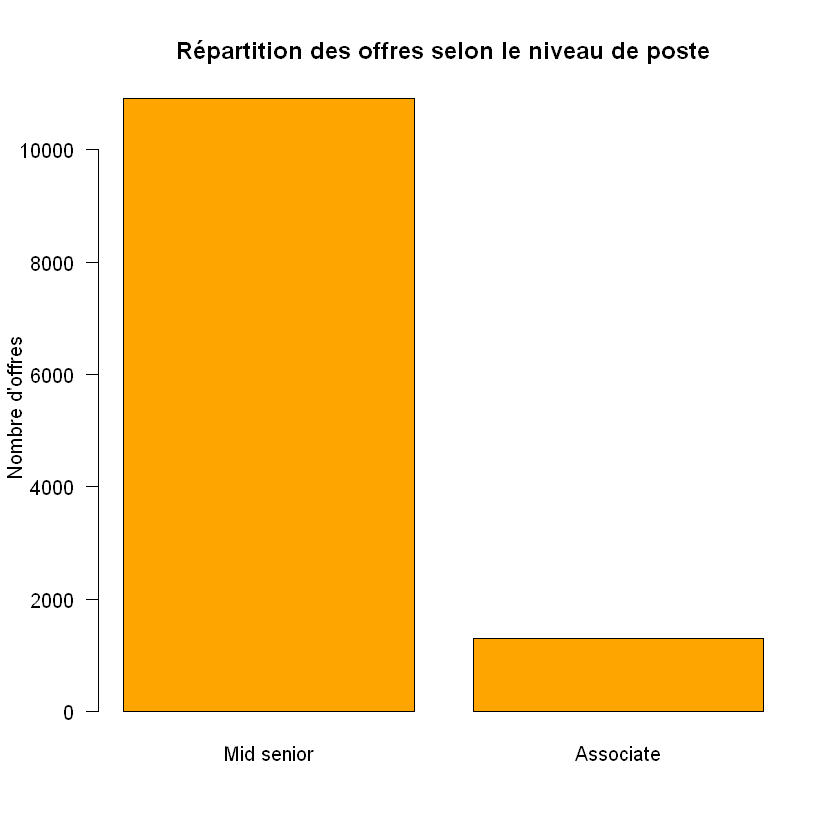

In [35]:
# Graphique : répartition des niveaux de poste
barplot(
  job_level_counts_df$count,
  names.arg = job_level_counts_df$job_level,
  col = "orange",
  main = "Répartition des offres selon le niveau de poste",
  ylab = "Nombre d'offres",
  las = 1
)


## Analyse et interprétation des résultats — Niveau des postes

L’analyse de la répartition des offres selon le niveau des postes montre une
dominance très marquée des profils de niveau intermédiaire à senior.

Les résultats indiquent que :
- Les postes de niveau **Mid senior** représentent la grande majorité des
  offres avec **10 919 annonces**.
- Les postes de niveau **Associate** sont nettement moins nombreux avec
  **1 298 annonces**.

Cette distribution met en évidence que le marché de l’emploi dans le domaine
de la Data étudié dans ce dataset est principalement orienté vers des profils
ayant déjà une expérience significative.

La faible proportion de postes de niveau Associate suggère que les opportunités
pour les profils débutants ou en début de carrière sont plus limitées par
rapport aux profils intermédiaires et expérimentés.

Ces résultats confirment les observations précédentes concernant la forte
demande pour des postes techniques avancés et renforcent l’idée d’un marché
data mature, axé sur l’expertise et l’expérience.


## Analyse des compétences les plus demandées

Cette étape vise à identifier les compétences techniques les plus fréquemment
mentionnées dans les offres d’emploi.

Le dataset des compétences contient, pour chaque offre, une liste de compétences
sous forme de texte. L’analyse consiste à :
- Séparer les compétences individuelles
- Compter leur fréquence d’apparition
- Identifier les compétences les plus demandées sur le marché de la Data

Les résultats permettront de mettre en évidence les technologies, outils et
compétences clés recherchés par les entreprises.


In [36]:
# Séparation des compétences (séparées par des virgules)
skills_vector <- unlist(strsplit(job_skills$job_skills, ","))

# Nettoyage des espaces
skills_vector <- trimws(skills_vector)

# Suppression des valeurs vides
skills_vector <- skills_vector[skills_vector != ""]

# Comptage des compétences
skill_counts <- table(skills_vector)

# Conversion en data.frame et tri décroissant
skill_counts_df <- as.data.frame(skill_counts)
names(skill_counts_df) <- c("skill", "count")

skill_counts_df <- skill_counts_df[
  order(-skill_counts_df$count),
]

# Affichage des 15 compétences les plus demandées
head(skill_counts_df, 15)


,skill,count
57311,Python,4801
65426,SQL,4606
15256,Communication,2498
19317,Data Analysis,2181
43550,Machine Learning,1966
7028,AWS,1740
68560,Tableau,1685
23155,Data Visualization,1562
57949,R,1542
40675,Java,1414


## Analyse et interprétation des résultats — Compétences les plus demandées

L’analyse des compétences met en évidence une forte domination des compétences
techniques fondamentales, combinées à des compétences analytiques et
transversales.

Les résultats montrent que :
- **Python** est la compétence la plus demandée avec **4 801 occurrences**,
  confirmant son rôle central dans les métiers de la Data.
- **SQL** arrive en deuxième position avec **4 606 occurrences**, soulignant
  l’importance de la manipulation et de l’extraction des données.
- Les compétences analytiques telles que **Data Analysis** (**2 181**) et
  **Machine Learning** (**1 966**) sont fortement représentées.
- Les technologies liées aux plateformes et outils data comme **AWS**,
  **Tableau**, **Spark** et **R** apparaissent également parmi les compétences
  les plus recherchées.
- Des compétences transversales telles que **Communication**, **Teamwork** et
  **Project Management** figurent dans le top des compétences, montrant que les
  entreprises valorisent aussi les capacités de collaboration et de gestion.

Ces résultats indiquent que le marché de l’emploi dans la Data recherche des
profils polyvalents, combinant des compétences techniques solides, une capacité
d’analyse avancée et des compétences humaines essentielles pour le travail en
équipe et la gestion de projets data complexes.


## Analyse croisée des compétences par métier

Cette analyse vise à étudier les compétences les plus demandées en fonction
des intitulés de postes.

L’objectif est d’identifier :
- Les compétences dominantes associées aux métiers les plus fréquents
- Les différences de compétences selon le type de poste
- Les compétences clés qui caractérisent certains rôles spécifiques
  (Data Engineer, Data Analyst, Data Scientist, etc.)

Cette analyse permettra de mieux comprendre l’adéquation entre les métiers
et les compétences techniques demandées par le marché.


In [37]:
# Création du dataset joint métier / compétences
jobs_skills_merged <- merge(
  job_postings[, c("job_link", "job_title")],
  job_skills,
  by = "job_link"
)

# Top 5 métiers 
top_jobs <- names(sort(table(jobs_skills_merged$job_title), decreasing = TRUE))[1:5]

# Boucle sur chaque métier
for (job in top_jobs) {

  cat("\n==============================\n")
  cat("Métier :", job, "\n")
  cat("==============================\n")

  # Filtrage des compétences du métier
  skills_text <- jobs_skills_merged$job_skills[
    jobs_skills_merged$job_title == job
  ]

  # Séparation et nettoyage
  skills_vector <- unlist(strsplit(skills_text, ","))
  skills_vector <- trimws(skills_vector)
  skills_vector <- skills_vector[skills_vector != ""]

  # Comptage des compétences
  skill_counts <- sort(table(skills_vector), decreasing = TRUE)

  # Affichage Top 5 skills
  print(head(skill_counts, 5))
}



Métier : Senior Data Engineer 
skills_vector
          Python              SQL Data Engineering            Spark 
             236              190              135              119 
            Java 
             116 

Métier : Senior Data Analyst 
skills_vector
               SQL             Python      Data Analysis            Tableau 
               142                 97                 84                 79 
Data Visualization 
                71 

Métier : Data Engineer 
skills_vector
          Python              SQL Data Engineering              AWS 
              99               89               70               39 
           Spark 
              38 

Métier : Senior MLOps Engineer 
skills_vector
  Probabilistic Graphs Reinforcement Learning                    NLP 
                   124                    123                    114 
           Flexibility                   LLMs 
                   113                    113 

Métier : Data Analyst 
skills_vector
         

## Analyse croisée des compétences par métier

L’analyse croisée des compétences par métier met en évidence des différences
claires entre les profils recherchés selon l’intitulé du poste, tout en
confirmant l’importance de certaines compétences communes.

Pour le poste de **Senior Data Engineer**, les compétences les plus demandées
sont principalement orientées vers l’ingénierie des données et les technologies
big data, avec une forte dominance de **Python**, **SQL**, **Data Engineering**
et **Spark**, ainsi qu’une présence notable de **Java**. Cela reflète le rôle
central de ce métier dans la conception et la gestion des pipelines data à
grande échelle.

Le poste de **Senior Data Analyst** met davantage l’accent sur l’analyse et la
visualisation des données. Les compétences dominantes sont **SQL**, **Python**,
**Data Analysis**, **Tableau** et **Data Visualization**, ce qui correspond aux
missions d’exploration, d’interprétation et de restitution des données.

Pour le métier de **Data Engineer**, on observe également une forte présence de
**Python** et **SQL**, accompagnée de compétences liées aux plateformes cloud
telles que **AWS**, confirmant l’importance des environnements cloud dans les
architectures data modernes.

De manière générale, cette analyse montre que :
- **Python** et **SQL** sont des compétences transversales essentielles,
  présentes dans tous les métiers analysés.
- Les postes orientés ingénierie privilégient les technologies big data et
  cloud (Spark, AWS, Data Engineering).
- Les postes orientés analyse privilégient les outils d’analyse et de
  visualisation (Tableau, Data Visualization).

Ces résultats illustrent clairement la spécialisation des compétences selon les
métiers, tout en mettant en évidence un socle commun de compétences techniques
indispensables dans le domaine de la Data.


## Visualisation des résultats

Afin de faciliter l’interprétation des résultats, des graphiques simples sont
utilisés pour représenter visuellement les principales tendances observées
dans les données.

Les visualisations permettent de :
- Comparer rapidement les catégories
- Identifier les dominances et déséquilibres
- Appuyer les analyses quantitatives par des représentations graphiques

Les graphiques suivants illustrent les métiers les plus demandés et la
répartition géographique des offres.


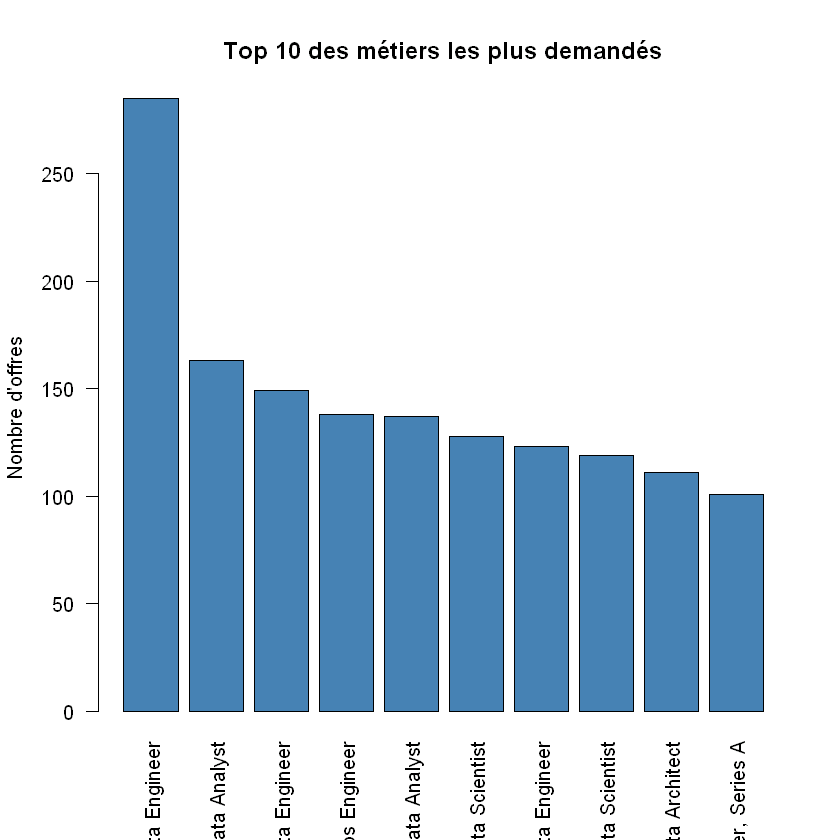

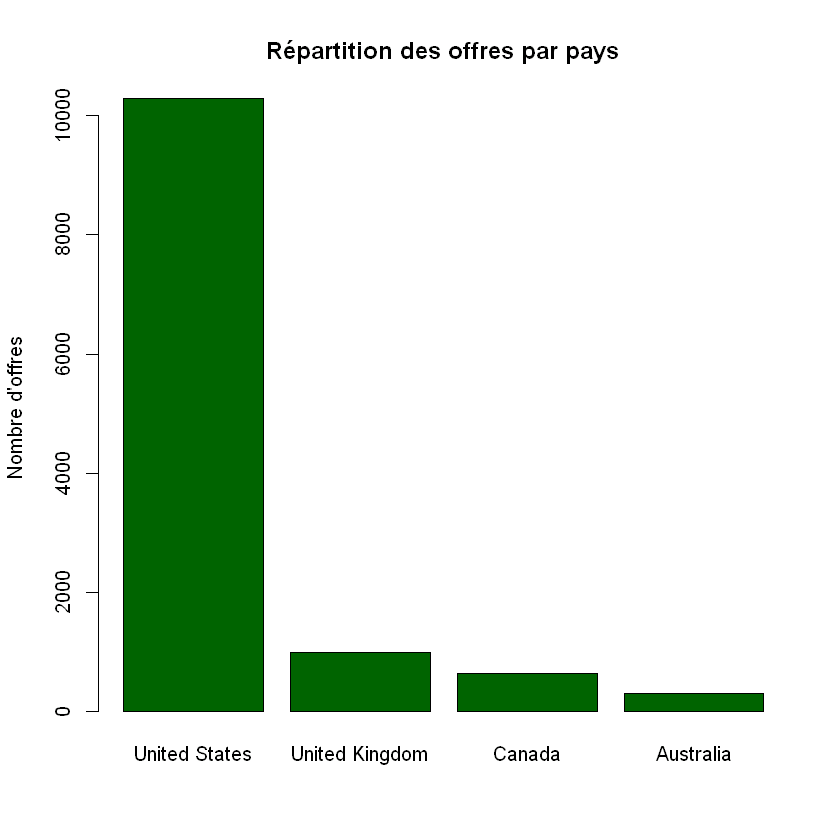

In [38]:
# ---------- Graph 1 : Top 10 métiers les plus demandés ----------

top_jobs <- job_title_counts_df[1:10, ]

barplot(
  top_jobs$count,
  names.arg = top_jobs$job_title,
  las = 2,
  col = "steelblue",
  main = "Top 10 des métiers les plus demandés",
  ylab = "Nombre d'offres"
)

# ---------- Graph 2 : Répartition des offres par pays ----------

barplot(
  country_counts_df$count,
  names.arg = country_counts_df$country,
  col = "darkgreen",
  main = "Répartition des offres par pays",
  ylab = "Nombre d'offres"
)


## Synthèse chiffrée du marché (Key Insights)

Cette section présente une synthèse quantitative des principaux résultats
afin de résumer rapidement les tendances observées dans le marché de l’emploi
Data analysé.

Les indicateurs clés permettent de :
- Donner une vue d’ensemble rapide du dataset
- Appuyer les analyses précédentes par des chiffres synthétiques
- Faciliter la lecture pour un rapport ou une soutenance


In [39]:
# Indicateurs clés du dataset

# Nombre total d'offres
total_jobs <- nrow(job_postings)

# Nombre de pays uniques
total_countries <- length(unique(job_postings$search_country))

# Nombre de métiers uniques
total_job_titles <- length(unique(job_postings$job_title))

# Nombre total de compétences uniques
total_unique_skills <- length(unique(skills_vector))

# Pourcentage de postes Mid senior
pct_mid_senior <- round(
  sum(job_postings$job_level == "Mid senior") / total_jobs * 100, 1
)

# Affichage des indicateurs
cat("Nombre total d'offres :", total_jobs, "\n")
cat("Nombre de pays :", total_countries, "\n")
cat("Nombre de métiers uniques :", total_job_titles, "\n")
cat("Nombre de compétences uniques :", total_unique_skills, "\n")
cat("Pourcentage de postes Mid senior :", pct_mid_senior, "%\n")


Nombre total d'offres : 12217 
Nombre de pays : 4 
Nombre de métiers uniques : 6484 
Nombre de compétences uniques : 1252 
Pourcentage de postes Mid senior : 89.4 %


## Interprétation de la synthèse chiffrée

La synthèse chiffrée met en évidence plusieurs caractéristiques importantes du
marché de l’emploi dans le domaine de la Data analysé dans ce projet.

Le dataset contient **12 217 offres d’emploi**, ce qui constitue un volume
significatif permettant d’obtenir des résultats représentatifs des tendances
du marché. Ces offres sont réparties sur **4 pays**, indiquant une forte
concentration géographique des opportunités, principalement dans des pays
anglophones.

On observe une grande diversité des intitulés de postes, avec **6 484 métiers
uniques**, ce qui reflète la variété des rôles, des spécialisations et des
appellations utilisées par les entreprises dans le domaine de la Data.

Le nombre élevé de **1 252 compétences uniques** souligne la richesse et la
complexité des profils recherchés, combinant des compétences techniques,
analytiques et transversales.

Enfin, la proportion très élevée de postes de niveau **Mid senior (89,4 %)**
montre que le marché de l’emploi étudié est majoritairement orienté vers des
profils expérimentés. Les opportunités pour les profils débutants apparaissent
plus limitées, ce qui confirme la forte exigence en termes d’expérience dans
les métiers de la Data.

Cette synthèse globale renforce les analyses précédentes et met en évidence un
marché mature, spécialisé et fortement axé sur l’expertise.


## Conclusion générale

Ce projet avait pour objectif d’analyser le marché de l’emploi dans le domaine
de la Data à partir d’un ensemble d’offres d’emploi réelles, en mettant l’accent
sur les métiers, la localisation géographique, les compétences demandées et les
niveaux d’expérience requis.

L’analyse a montré que le marché est fortement dominé par des postes techniques
orientés vers l’ingénierie des données et l’analyse, avec une demande
particulièrement élevée pour des rôles tels que **Senior Data Engineer**,
**Senior Data Analyst** et **Data Engineer**. La répartition géographique met en
évidence une concentration très marquée des offres dans un nombre limité de
pays, principalement les États-Unis, confirmant leur rôle central dans
l’écosystème Data.

L’étude des compétences révèle que **Python** et **SQL** constituent le socle
technique indispensable pour la majorité des métiers de la Data, tandis que
des compétences complémentaires telles que le cloud (AWS), les outils de
visualisation (Tableau) et les technologies big data (Spark) jouent un rôle clé
selon le type de poste. Les compétences transversales, notamment la
communication et le travail en équipe, apparaissent également comme des
éléments importants dans les profils recherchés.

Un résultat marquant de ce projet est la très forte proportion de postes de
niveau **Mid senior**, indiquant que le marché de l’emploi Data étudié est
principalement orienté vers des profils expérimentés. Les opportunités pour
les profils juniors semblent plus limitées, ce qui souligne l’importance de
l’expérience pratique et de la spécialisation technique.

Dans l’ensemble, cette analyse met en évidence un marché de l’emploi Data
mature, exigeant et fortement spécialisé. Les résultats obtenus peuvent servir
de base à une meilleure compréhension des attentes du marché, aussi bien pour
les étudiants et professionnels souhaitant orienter leur carrière que pour
les entreprises cherchant à positionner leurs besoins en compétences.


## Limites du projet et perspectives d’amélioration

Bien que ce projet fournisse une analyse détaillée et pertinente du marché de
l’emploi dans le domaine de la Data, certaines limites doivent être prises en
compte dans l’interprétation des résultats.

Tout d’abord, les données utilisées proviennent principalement d’offres
d’emploi publiées sur LinkedIn, ce qui peut introduire un biais de sélection.
Le dataset peut ne pas représenter l’ensemble du marché de l’emploi Data,
notamment les offres issues de petites entreprises, de startups locales ou
d’autres plateformes de recrutement.

Ensuite, la répartition géographique des offres est fortement concentrée sur
un nombre limité de pays, principalement anglophones. Cette concentration peut
limiter la généralisation des résultats à d’autres régions du monde où les
dynamiques du marché de l’emploi Data peuvent être différentes.

Par ailleurs, l’analyse des compétences repose sur des listes de compétences
textuelles extraites des offres d’emploi, sans traitement avancé du langage
naturel. Certaines compétences peuvent être redondantes, formulées de manière
différente ou regroupées de façon approximative.

Enfin, l’analyse ne prend pas en compte l’évolution temporelle des offres ni
les informations salariales, ce qui aurait permis d’étudier les tendances dans
le temps et la relation entre compétences, métiers et niveaux de rémunération.

### Perspectives d’amélioration

Plusieurs pistes d’amélioration peuvent être envisagées pour enrichir ce
projet :
- Intégrer une analyse temporelle afin d’étudier l’évolution des métiers et
  des compétences dans le temps.
- Mettre en place des techniques de traitement du langage naturel (NLP) pour
  analyser plus finement les descriptions de postes et regrouper les
  compétences de manière plus précise.
- Étendre l’analyse aux salaires afin d’évaluer l’impact des compétences et
  des métiers sur les niveaux de rémunération.
- Réaliser une segmentation plus avancée du marché à l’aide de méthodes de
  clustering pour identifier différents profils de métiers Data.

Ces améliorations permettraient d’approfondir l’analyse et d’obtenir une
vision encore plus complète et nuancée du marché de l’emploi dans le domaine
de la Data.
